# Supplementary Information: Holmes *et al.* 2017

# 4. Varying base expression level

In [7]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


## Building the model

In our first unpooled model, we treated each probe as if there were an effect relating the measured *output* intensity to the *input* intensity for that probe, specific to the probe ID.  We treated that output value as some linear function of the input value, where the intercept $\alpha$ as though was a single pooled value for all probes. 

Here, we'll change that assumption so that we consider each probe to have an intercept that is also specific to its *probe ID*. This is in effect equivalent to fitting a different linear model to each *probe ID*.

We construct the following model of the experiment:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \epsilon_i$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *probe ID*
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `sigma`: `real<lower=0>`, the error in the prediction

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a[probe[i]]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as $y \sim N(\hat{y}, \sigma^2)$.

In [2]:
# load clean, normalised, indexed data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_probe_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

In [3]:
# define unpooled stan model
unpooled_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=1, upper=J> probe[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  real<lower=0> sigma;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[probe[i]] + b[probe[i]] * x[i];
}
model {
  y ~ normal(y_hat, sigma);
}
"""

In [4]:
# relate python variables to stan variables
unpooled_data_dict = {'N': len(data),
                      'J': nprobes,
                      'probe': data['probe_index'] + 1,
                      'x': data['log_input'],
                      'y': data['log_output']}

In [5]:
# run stan fit
unpooled_fit = pystan.stan(model_code=unpooled_model,
                           data=unpooled_data_dict,
                           iter=1000, chains=2,
                           seed=tools.SEED)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea893bcfcd544b6213d01676f1caa5cf NOW.


In [8]:
# Save model to file, for reuse# Save fit to file, for reuse
unpermutedChains = unpooled_fit.extract()

unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook04.pkl', 'wb'))

## Inspecting the fit

In [9]:
# Get fits to alpha and beta by probe ID
alpha_estimates = pd.Series(unpooled_fit['a'].mean(0), index=probe_ids)
alpha_se = pd.Series(unpooled_fit['a'].std(0), index=probe_ids)
beta_estimates = pd.Series(unpooled_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(unpooled_fit['b'].std(0), index=probe_ids)

In [10]:
# Inspect the estimates
alpha_estimates.head()

A_07_P052986    1.442981
A_07_P045401    1.142223
A_07_P052976    0.727555
A_07_P045384    0.745646
A_07_P045369    1.387502
dtype: float64

In [11]:
# Inspect the estimates
beta_estimates.head()

A_07_P052986    0.158611
A_07_P045401    0.251615
A_07_P052976    0.418952
A_07_P045384    0.338553
A_07_P045369    0.582195
dtype: float64

### Intercept $\alpha_{j[i]}$

Taking the intercept first, we can get an overview of the mean and standard error of $\alpha$:

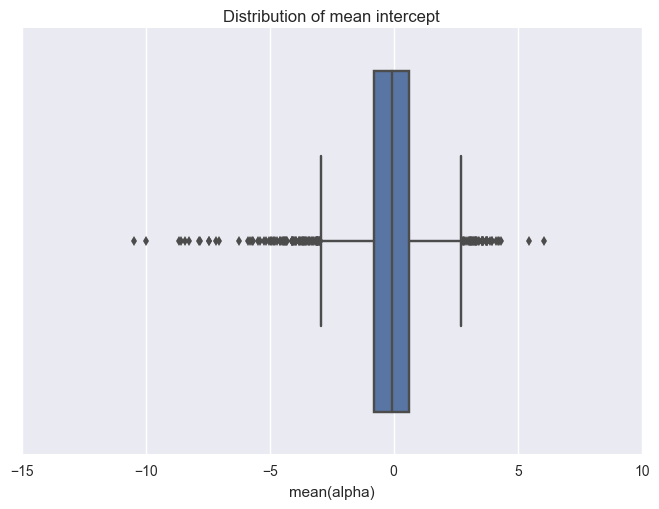

In [12]:
# Plot means distribution
g = sns.boxplot(alpha_estimates)
g.set_title("Distribution of mean intercept")
g.set_xlabel("mean(alpha)");

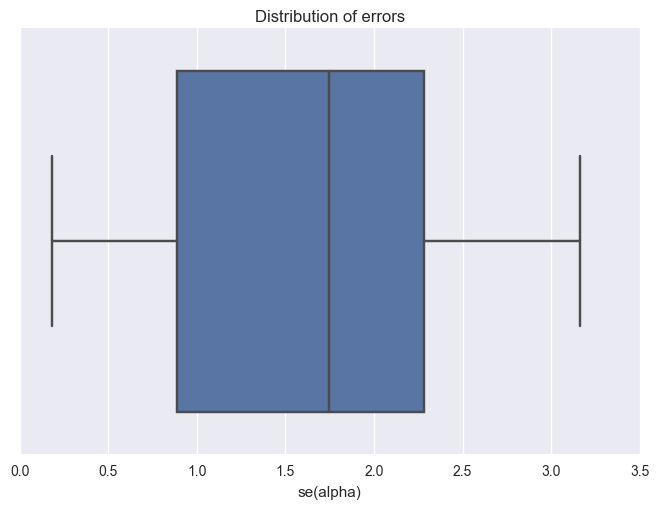

In [13]:
# Plot error distribution
g = sns.boxplot(alpha_se)
g.set_title("Distribution of errors")
g.set_xlabel("se(alpha)");

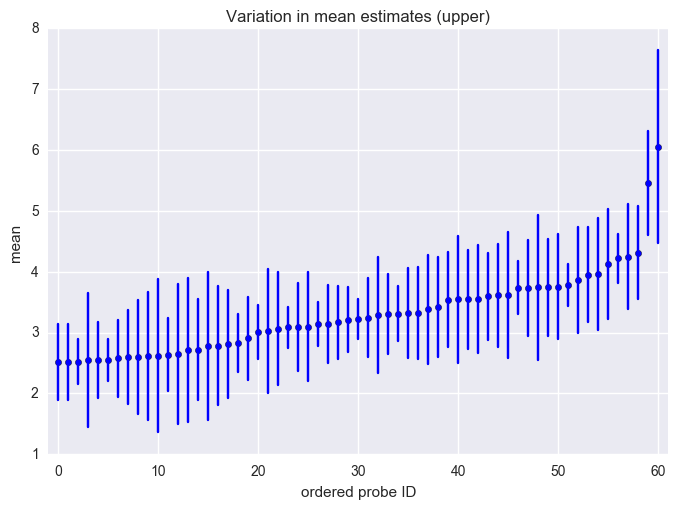

In [14]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, 2.5)

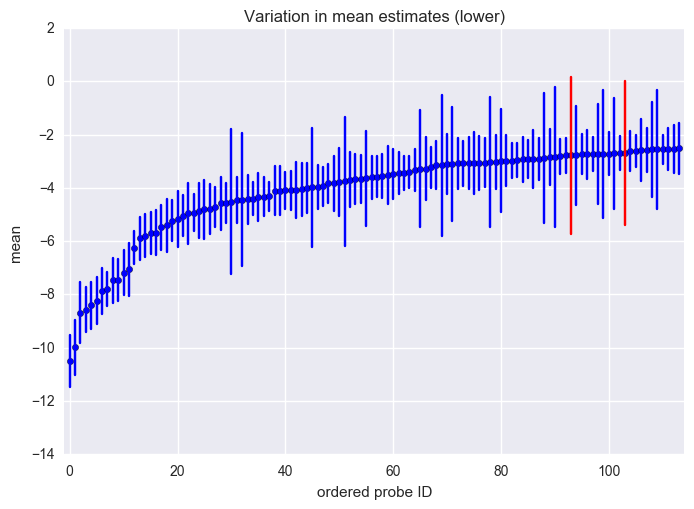

In [15]:
# errors for intercept outliers
tools.plot_threshold_errors(alpha_estimates, alpha_se, -2.5, upper=False)

### Slopes $\beta_{j[i]}$

The variation of slopes $\beta_{j[i]}$ by *probe ID* are the most interesting estimates, as they are indicative of the way *output* intensity measurements depend on *input* intensity measurements, and could help identify genes that are advantageous or disadvantageous in our experiment.

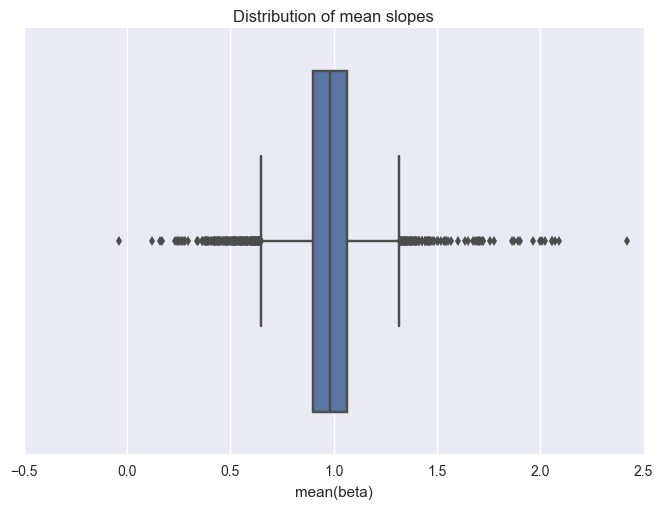

In [16]:
# Plot distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slopes")
g.set_xlabel("mean(beta)");

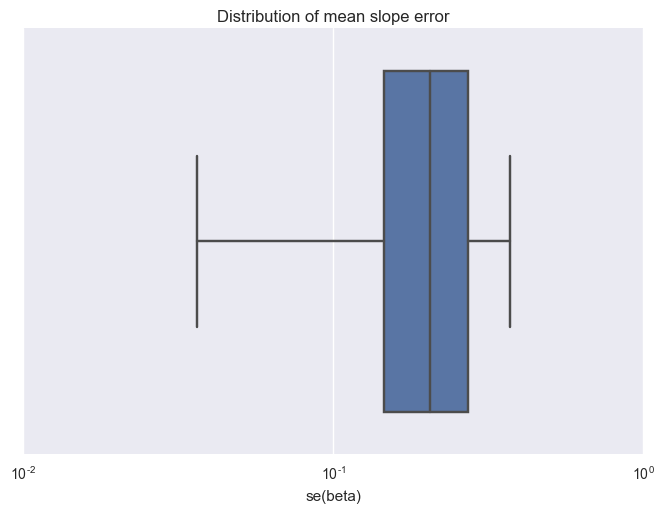

In [17]:
# Plot distribution
g = sns.boxplot(beta_se)
g.set_title("Distribution of mean slope error")
g.set_xscale("log")
g.set_xlabel("se(beta)");

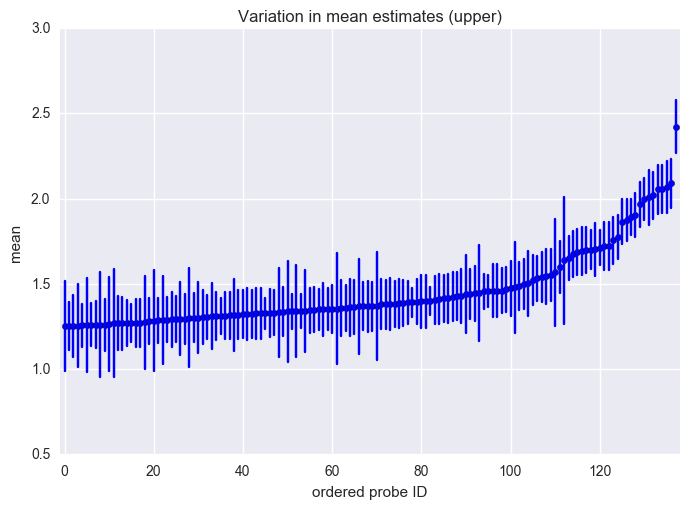

In [18]:
# plot all errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, 1.25)

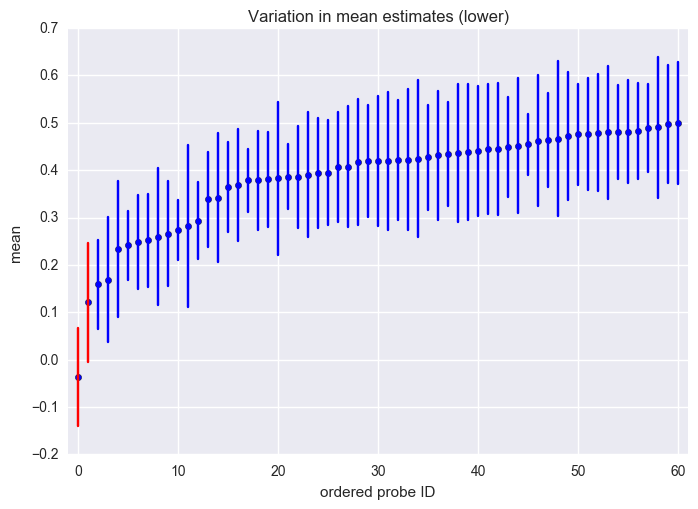

In [19]:
# plot all errors/means
tools.plot_threshold_errors(beta_estimates, beta_se, 0.5, upper=False)

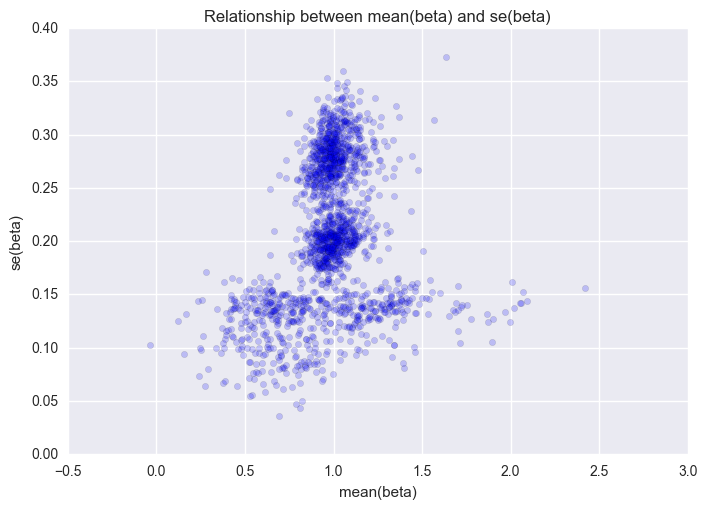

In [20]:
# How does estimate of error relate to error in the estimate
plt.scatter(beta_estimates, beta_se, alpha=0.2)
plt.title("Relationship between mean(beta) and se(beta)")
plt.xlabel("mean(beta)")
plt.ylabel("se(beta)");

In [21]:
data.head(40)

,dh10b_match,input,locus_tag,log_input,log_output,match,output,probe,replicate,sakai_match,treatment,probe_index,locus_index
0,0.0,13.354233,ECs1176,2.591833,2.352119,lcl|NC_002695.1_cds_NP_309203.1_1134,10.507812,A_07_P052986,1,1,0,0,0
1,0.0,6.815142,ECs1176,1.919147,2.431403,lcl|NC_002695.1_cds_NP_309203.1_1134,11.374824,A_07_P052986,2,1,0,0,0
2,0.0,146.893973,ECs1176,4.989711,2.125809,lcl|NC_002695.1_cds_NP_309203.1_1134,8.379672,A_07_P052986,3,1,0,0,0
3,0.0,0.629964,ECs1176,-0.462092,0.878914,lcl|NC_002695.1_cds_NP_309203.1_1134,2.408282,A_07_P052986,1,1,1,0,0
4,0.0,0.651612,ECs1176,-0.428306,1.853818,lcl|NC_002695.1_cds_NP_309203.1_1134,6.384148,A_07_P052986,2,1,1,0,0
5,0.0,7.188469,ECs1176,1.972478,0.642422,lcl|NC_002695.1_cds_NP_309203.1_1134,1.901080,A_07_P052986,3,1,1,0,0
6,0.0,8.442597,ECs1176,2.133290,2.260812,lcl|NC_002695.1_cds_NP_309203.1_1134,9.590875,A_07_P045401,1,1,0,1,0
7,0.0,5.823013,ECs1176,1.761818,2.566267,lcl|NC_002695.1_cds_NP_309203.1_1134,13.017137,A_07_P045401,2,1,0,1,0
8,0.0,145.411400,ECs1176,4.979567,1.865585,lcl|NC_002695.1_cds_NP_309203.1_1134,6.459714,A_07_P045401,3,1,0,1,0
9,0.0,0.572822,ECs1176,-0.557181,0.680997,lcl|NC_002695.1_cds_NP_309203.1_1134,1.975847,A_07_P045401,1,1,1,1,0
